In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('https://ai-jobs.net/salaries/download/salaries.csv')
df.drop_duplicates(inplace=True)
df.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Data Architect,363000,USD,363000,US,0,US,M
1,2024,SE,FT,Data Architect,139800,USD,139800,US,0,US,M
2,2024,MI,FT,Data Scientist,109000,USD,109000,US,100,US,M
3,2024,MI,FT,Data Scientist,93000,USD,93000,US,100,US,M
4,2024,MI,FT,Research Engineer,35000,EUR,38888,PT,0,PT,M
5,2024,MI,FT,Research Engineer,26000,EUR,28888,PT,0,PT,M
6,2024,SE,FT,Data Scientist,248600,USD,248600,US,0,US,M
7,2024,SE,FT,Data Scientist,149200,USD,149200,US,0,US,M
8,2024,SE,FT,Business Intelligence,175000,USD,175000,US,0,US,M
9,2024,SE,FT,Business Intelligence,150000,USD,150000,US,0,US,M


## Dropping appropriate columns
The salary combined with salary_currency is the same as the salary_in_usd column that is our target variable. It is debatable whether we can use the salary currency without the salary but realistically the currency should be highly correlated to the country column (with less granularity of course) so I will drop it.

In [3]:
drop_columns = ['salary','salary_currency']
df.drop(drop_columns,axis=1,inplace=True)
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Data Architect,363000,US,0,US,M
1,2024,SE,FT,Data Architect,139800,US,0,US,M
2,2024,MI,FT,Data Scientist,109000,US,100,US,M
3,2024,MI,FT,Data Scientist,93000,US,100,US,M
4,2024,MI,FT,Research Engineer,38888,PT,0,PT,M


## Consolidating Job Titles

In [4]:
np.sort(df['job_title'].unique())

array(['AI Architect', 'AI Developer', 'AI Engineer',
       'AI Product Manager', 'AI Programmer', 'AI Research Engineer',
       'AI Scientist', 'AWS Data Architect', 'Admin & Data Analyst',
       'Analytics Engineer', 'Analytics Engineering Manager',
       'Applied Data Scientist', 'Applied Machine Learning Engineer',
       'Applied Machine Learning Scientist', 'Applied Scientist',
       'Autonomous Vehicle Technician', 'Azure Data Engineer',
       'BI Analyst', 'BI Data Analyst', 'BI Data Engineer',
       'BI Developer', 'Big Data Architect', 'Big Data Engineer',
       'Business Data Analyst', 'Business Intelligence',
       'Business Intelligence Analyst',
       'Business Intelligence Data Analyst',
       'Business Intelligence Developer',
       'Business Intelligence Engineer', 'Business Intelligence Lead',
       'Business Intelligence Manager',
       'Business Intelligence Specialist', 'Cloud Data Architect',
       'Cloud Data Engineer', 'Cloud Database Engineer',
 

The issue here is how subjective the consolidation is due to my own lack of domain knowledge. As there are few words, I will instead split each title into individual words and encode them for Machine Learning during that stage

### Extracting full list of titles from html code on source website
Rather than simply grabbing the list of job titles in the dataset, I can grab the full list of possible titles from the data source (https://ai-jobs.net/) since the data is entered using a drop down menu with a limited number of options.

For this, I downloaded the chunk of html code for the drop down with the list of available jobs and will clean that to make a full list of job titles. Since I have the full list of possible options, and it should not change, there would not be a scenario where a word in the test set would not have a column to account for it.

In [5]:
with open('Job_title_span_html.txt') as file:
    job_html = file.read()

raw_list = job_html.replace('<','>').split('>')
raw_list = raw_list[14:-1:4]
print('Sample of raw job titles from the html code:\n')
print(raw_list[:10])
print('Number of job titles: {}'.format(len(raw_list)))

Sample of raw job titles from the html code:

['Admin &amp; Data Analyst', 'AI Architect', 'AI Developer', 'AI Engineer', 'AI Product Manager', 'AI Programmer', 'AI Research Engineer', 'AI Research Scientist', 'AI Scientist', 'Analytics Engineer']
Number of job titles: 219


In [6]:
# Adding in all the acronyms already present in the dataset and duplicated text from spelling variations and fillers. 
# Removing 1 from Data Scientist 1 as it is simply a data scientist position 
# Consolidated Engineering/Engineer, Scientist, Science, Analytics/Analyst etc. Full list in the replacements dictionary.
replacements = [('&amp; ',''), #html formatting
                (' 1',''),
                (' of',''),
                (' in',''),
                ('and',''),
                ('Business Intelligence','BI'),
                ('Modeler','Modeller'),
                ('Data Operations','DataOps'),
                ('Machine Learning Operations','MLOps'),
                ('Machine Learning','ML'),
                ('Engineering','Engineer'), # this order matters to avoid creating the word engineeringing
                ('Scientist','Science'),
                ('Analyst','Analytics'),
                ('Researcher','Research'),
                ('Strategist','Strategy'),
                ('data operator','Data Operator'),
                ('Solutions','Solution'),
                ('Financial','Finance')
               ]
#  Not combining Manager and Management because they are used in different contexts
titles_tidy = []
for title in raw_list:
    for old,new in replacements:
        title = title.replace(old,new)
    titles_tidy.append(title)

print('Sample of tidy job titles from the html code:\n')
print(titles_tidy[:10])
print('Number of job titles: {}'.format(len(raw_list)))

replacements_dict = dict(zip(raw_list,titles_tidy))

with open('replacements.pkl', 'wb') as file:
    pickle.dump(replacements_dict,file)

Sample of tidy job titles from the html code:

['Admin Data Analytics', 'AI Architect', 'AI Developer', 'AI Engineer', 'AI Product Manager', 'AI Programmer', 'AI Research Engineer', 'AI Research Science', 'AI Science', 'Analytics Engineer']
Number of job titles: 219


In [7]:
complete_title_words = []
for title in titles_tidy:
    complete_title_words = complete_title_words + title.split()
    
complete_title_words = list(set(complete_title_words))
complete_title_words.sort()

print('Vocabulary of possible words in consolidated job title column ({} words)\n'.format(len(complete_title_words)))
print(complete_title_words)

Vocabulary of possible words in consolidated job title column (107 words)

['AI', 'AWS', 'Admin', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Bear', 'Big', 'Business', 'CRM', 'Chain', 'Clinical', 'Cloud', 'Commercial', 'Compliance', 'Computer', 'Consultant', 'Customer', 'Data', 'DataOps', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Digital', 'Director', 'ETL', 'Engineer', 'Enterprise', 'Entry', 'Executive', 'Expert', 'Finance', 'Fraud', 'Game', 'Generative', 'Geophysicist', 'Google', 'Graduate', 'Growth', 'HR', 'Head', 'Healthcare', 'IQ', 'IT', 'Imaging', 'Infrastructure', 'Insight', 'Integration', 'Intern', 'Lead', 'Learning', 'Level', 'Logistics', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Master', 'Modeller', 'NLP', 'Operations', 'Operator', 'Owner', 'People', 'Phd', 'Pipeline', 'Portfolio', 'Power', 'Practitioner', 'Pricing', 'Principal', 'Process', 'Procurement', 'Product', 'Programmer', 'Prompt', 'P

This list `complete_title_words` can be saved for later as `vocabulary.json` when using count vectorizer as the vocabulary argument.

In [8]:
with open("vocabulary.json", 'w') as file:
    json.dump(complete_title_words, file) 

### Creating consolidated titles column

In [9]:
df['job_title_clean'] = df['job_title'].map(replacements_dict)
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_clean
0,2024,SE,FT,Data Architect,363000,US,0,US,M,Data Architect
1,2024,SE,FT,Data Architect,139800,US,0,US,M,Data Architect
2,2024,MI,FT,Data Scientist,109000,US,100,US,M,Data Science
3,2024,MI,FT,Data Scientist,93000,US,100,US,M,Data Science
4,2024,MI,FT,Research Engineer,38888,PT,0,PT,M,Research Engineer


In [10]:
print('Number of unique titles in:\n original column: {old} \n new column {new}'.format(
    old=len(df['job_title'].unique()),new=len(df['job_title_clean'].unique())))

Number of unique titles in:
 original column: 141 
 new column 127


While this step is not necessarily decreasing the number of unique job titles by a large amount, this will aid in analysis and ML and reduce the number of columns when using the count_vectorizer encoder

### New feature creation
Creating a new field `outsourced` which is a True/False value of whether the employee is based in the same country as the company

In [11]:
df['outsourced'] = df['employee_residence'] != df['company_location']
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_clean,outsourced
0,2024,SE,FT,Data Architect,363000,US,0,US,M,Data Architect,False
1,2024,SE,FT,Data Architect,139800,US,0,US,M,Data Architect,False
2,2024,MI,FT,Data Scientist,109000,US,100,US,M,Data Science,False
3,2024,MI,FT,Data Scientist,93000,US,100,US,M,Data Science,False
4,2024,MI,FT,Research Engineer,38888,PT,0,PT,M,Research Engineer,False


## Data Visualization

### Job title

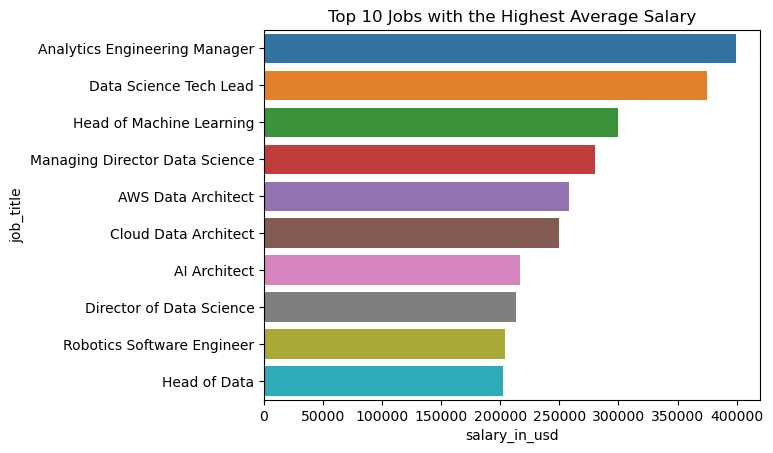

In [12]:
salary_by_title = df[['job_title','salary_in_usd']].groupby('job_title').agg(['mean','count']).sort_values(by=('salary_in_usd','mean'),ascending=False).reset_index()

sns.barplot(data = salary_by_title.head(10), x=('salary_in_usd','mean'), y='job_title')
plt.title('Top 10 Jobs with the Highest Average Salary')
plt.xlabel('salary_in_usd')
plt.show()

In [13]:
salary_by_title.head(10)

job_title  salary_in_usd      
                                            mean count
0   Analytics Engineering Manager  399880.000000     1
1          Data Science Tech Lead  375000.000000     1
2        Head of Machine Learning  299758.428571     7
3  Managing Director Data Science  280000.000000     2
4              AWS Data Architect  258000.000000     1
5            Cloud Data Architect  250000.000000     1
6                    AI Architect  216827.571429    14
7        Director of Data Science  213454.387097    31
8      Robotics Software Engineer  203750.000000     4
9                    Head of Data  202066.736842    38

The top 10 salaried positions are full of Lead, Manager and Director positions however it is notable that at the top end, the 'mean' salary is often a singular data point so how representative these numbers are is not reliable. Hence why I am going to split the titles and use a bag of words model rather the titles as individual categories.

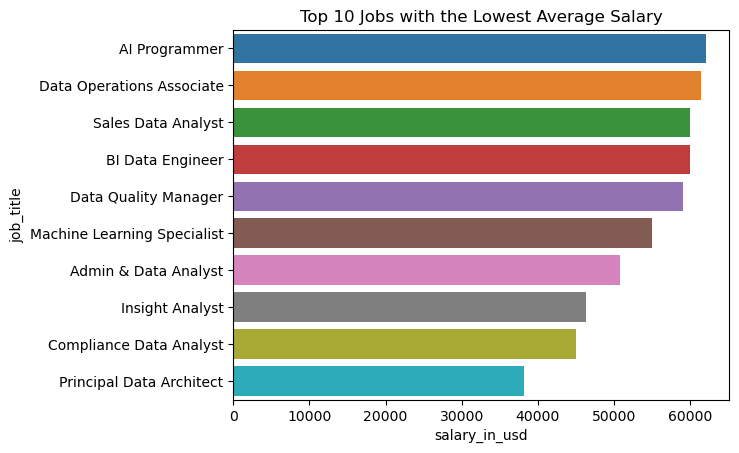

In [14]:
sns.barplot(data = salary_by_title.tail(10), x=('salary_in_usd','mean'), y='job_title')
plt.title('Top 10 Jobs with the Lowest Average Salary')
plt.xlabel('salary_in_usd')
plt.show()

In [15]:
salary_by_title.tail(10)

job_title salary_in_usd      
                                          mean count
131                AI Programmer  62042.000000     7
132    Data Operations Associate  61399.000000     4
133           Sales Data Analyst  60000.000000     1
134             BI Data Engineer  60000.000000     1
135         Data Quality Manager  59059.000000     2
136  Machine Learning Specialist  55000.000000     2
137         Admin & Data Analyst  50740.666667     3
138              Insight Analyst  46339.833333     6
139      Compliance Data Analyst  45000.000000     2
140     Principal Data Architect  38154.000000     1

At the bottom of the salary list, there also the issue of limited data so the average salaries may be only a single reported value. In this case also, the salary in USD may be much lower than expected based on the company or employee country. Of note is the lowest salary position 18,000 USD for a Principal Data Architect position seems low.

In [16]:
df.loc[df['job_title']=='Principal Data Architect']

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_clean,outsourced
11904,2022,SE,FT,Principal Data Architect,38154,IN,100,IN,L,Principal Data Architect,False


However the employee is located in India where the 38,154 USD when converted to local currency equates to about 3 million INR. Compared to a yearly cost of living of around 1.2 million INR for a family of 4 according to https://www.numbeo.com/cost-of-living/country_result.jsp?country=India this value is so not anomalously low after all.

In [17]:
salary_by_clean_title = df[['job_title_clean','salary_in_usd']].groupby('job_title_clean').agg(['mean','count']).sort_values(by=('salary_in_usd','mean'),ascending=False).reset_index()
salary_by_clean_title.head(10)

job_title_clean  salary_in_usd      
                                            mean count
0      Analytics Engineer Manager  399880.000000     1
1          Data Science Tech Lead  375000.000000     1
2                         Head ML  299758.428571     7
3  Managing Director Data Science  280000.000000     2
4              AWS Data Architect  258000.000000     1
5            Cloud Data Architect  250000.000000     1
6                    AI Architect  216827.571429    14
7           Director Data Science  213454.387097    31
8      Robotics Software Engineer  203750.000000     4
9                       Head Data  202066.736842    38

In [18]:
salary_by_clean_title.tail(10)

job_title_clean salary_in_usd      
                                        mean count
116       ML Research Engineer  62504.000000     4
117              AI Programmer  62042.000000     7
118          DataOps Associate  61399.000000     4
119       Sales Data Analytics  60000.000000     1
120           BI Data Engineer  60000.000000     1
121       Data Quality Manager  59059.000000     2
122              ML Specialist  55000.000000     2
123          Insight Analytics  46339.833333     6
124  Compliance Data Analytics  45000.000000     2
125   Principal Data Architect  38154.000000     1

The top 10 and bottom 10 salaried position lists do not change by much from the title cleaning however it is not a big suprise as the major benefit of the cleaning and consoludation is for ML preprocessing

### Experience Level

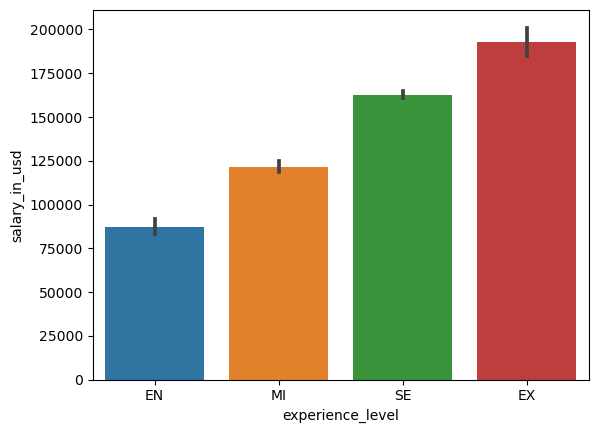

In [19]:
sns.barplot(data = df, x= 'experience_level',y='salary_in_usd',order=['EN','MI','SE','EX'])
plt.show()

The `experience_level` column appears to be an excellent indicator for salary, showing an apparent linear increase in the average salary with increasing seniority.

### Employment Type

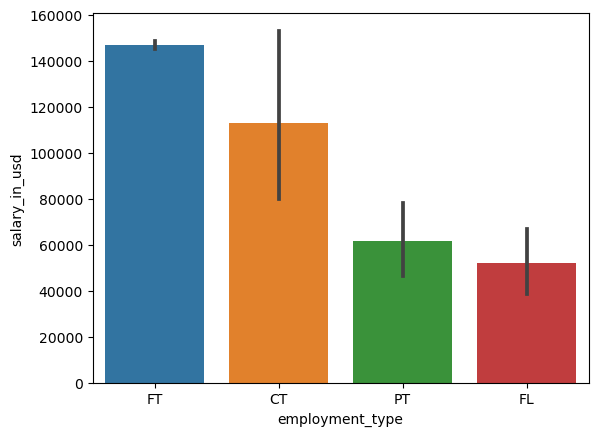

employment_type
FT    7885
CT      25
PT      22
FL      12
Name: count, dtype: int64

In [20]:
sns.barplot(data = df, x= 'employment_type',y='salary_in_usd')
plt.show()

df['employment_type'].value_counts()

The `employment_type` has a significant impact on salary as expected. There is an expectectation that part time will make less than full time considering fewer worked hours and freelance seems to be very similar to part-time with contract work close to full time but with notably high variance.
Part-time, Freelance and Contract employment all have very high variance, likely attributable to the the very small sample sizes.

### Work Model

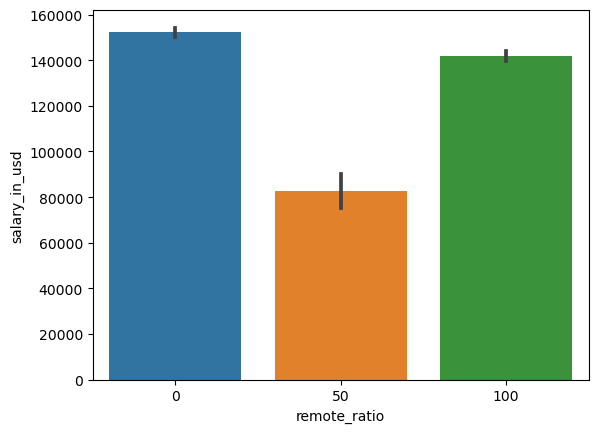

remote_ratio
0      4798
100    2913
50      233
Name: count, dtype: int64

In [21]:
sns.barplot(data = df, x= 'remote_ratio',y='salary_in_usd')
plt.show()

df['remote_ratio'].value_counts()

Based on the bargraph, on-site workers have a slightly higher salary than remote workers but hybrid workers seem have a notably lower average salary, almost half of on-site/remote workers.

### Work Year

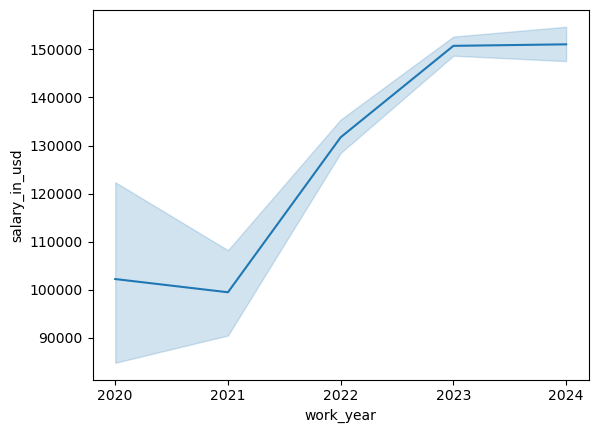

work_year
2020      75
2021     216
2022    1113
2023    4628
2024    1912
Name: count, dtype: int64

In [22]:
ax = sns.lineplot(data = df,x='work_year',y='salary_in_usd')
ax.set_xticks(list(range(df['work_year'].min(),df['work_year'].max()+1)))
plt.show()
df['work_year'].value_counts().sort_index()

There is generally an upward trend in salaries over the past 5 years.

### Employee Country and Company Country

In [23]:
df['outsourced'].value_counts()

outsourced
False    7817
True      127
Name: count, dtype: int64

The vast majority (~98%) of employees are not outsourced so I will primarily look at the employee residence for visualization since the visualisations would be roughly the same for company location. Then will look at outsourcing at the end of this section.

In [24]:
salaries_per_country = df[['employee_residence','salary_in_usd']].groupby('employee_residence').count().sort_values(by='salary_in_usd',ascending=False).reset_index()
salaries_per_country.columns = ['employee_residence','reported_salaries']
salaries_per_country['percentage of total'] = np.round(100 * salaries_per_country['reported_salaries'] / len(df))
salaries_per_country

,employee_residence,reported_salaries,percentage of total
0,US,6466,81.0
1,GB,459,6.0
2,CA,293,4.0
3,DE,84,1.0
4,ES,73,1.0
...,...,...,...
82,JE,1,0.0
83,KW,1,0.0
84,LU,1,0.0
85,MU,1,0.0


In [25]:
print('Number of countries with only 1 salary reported: {}'.format(np.sum(salaries_per_country['reported_salaries']==1)))

Number of countries with only 1 salary reported: 24


The dataset is quite unbalanced regarding the countries represented as 90% of all the salaries reported are from the US, the UK and Canada and with 26 countries only represented once. The major issue with only having one sample per country is that when data is split to create the training and test set, it is likely that data will be present in the test set and was not in the test set. So, can we drop the country column or does it impact the reported salary significantly?

<Axes: xlabel='salary_in_usd', ylabel='employee_residence'>

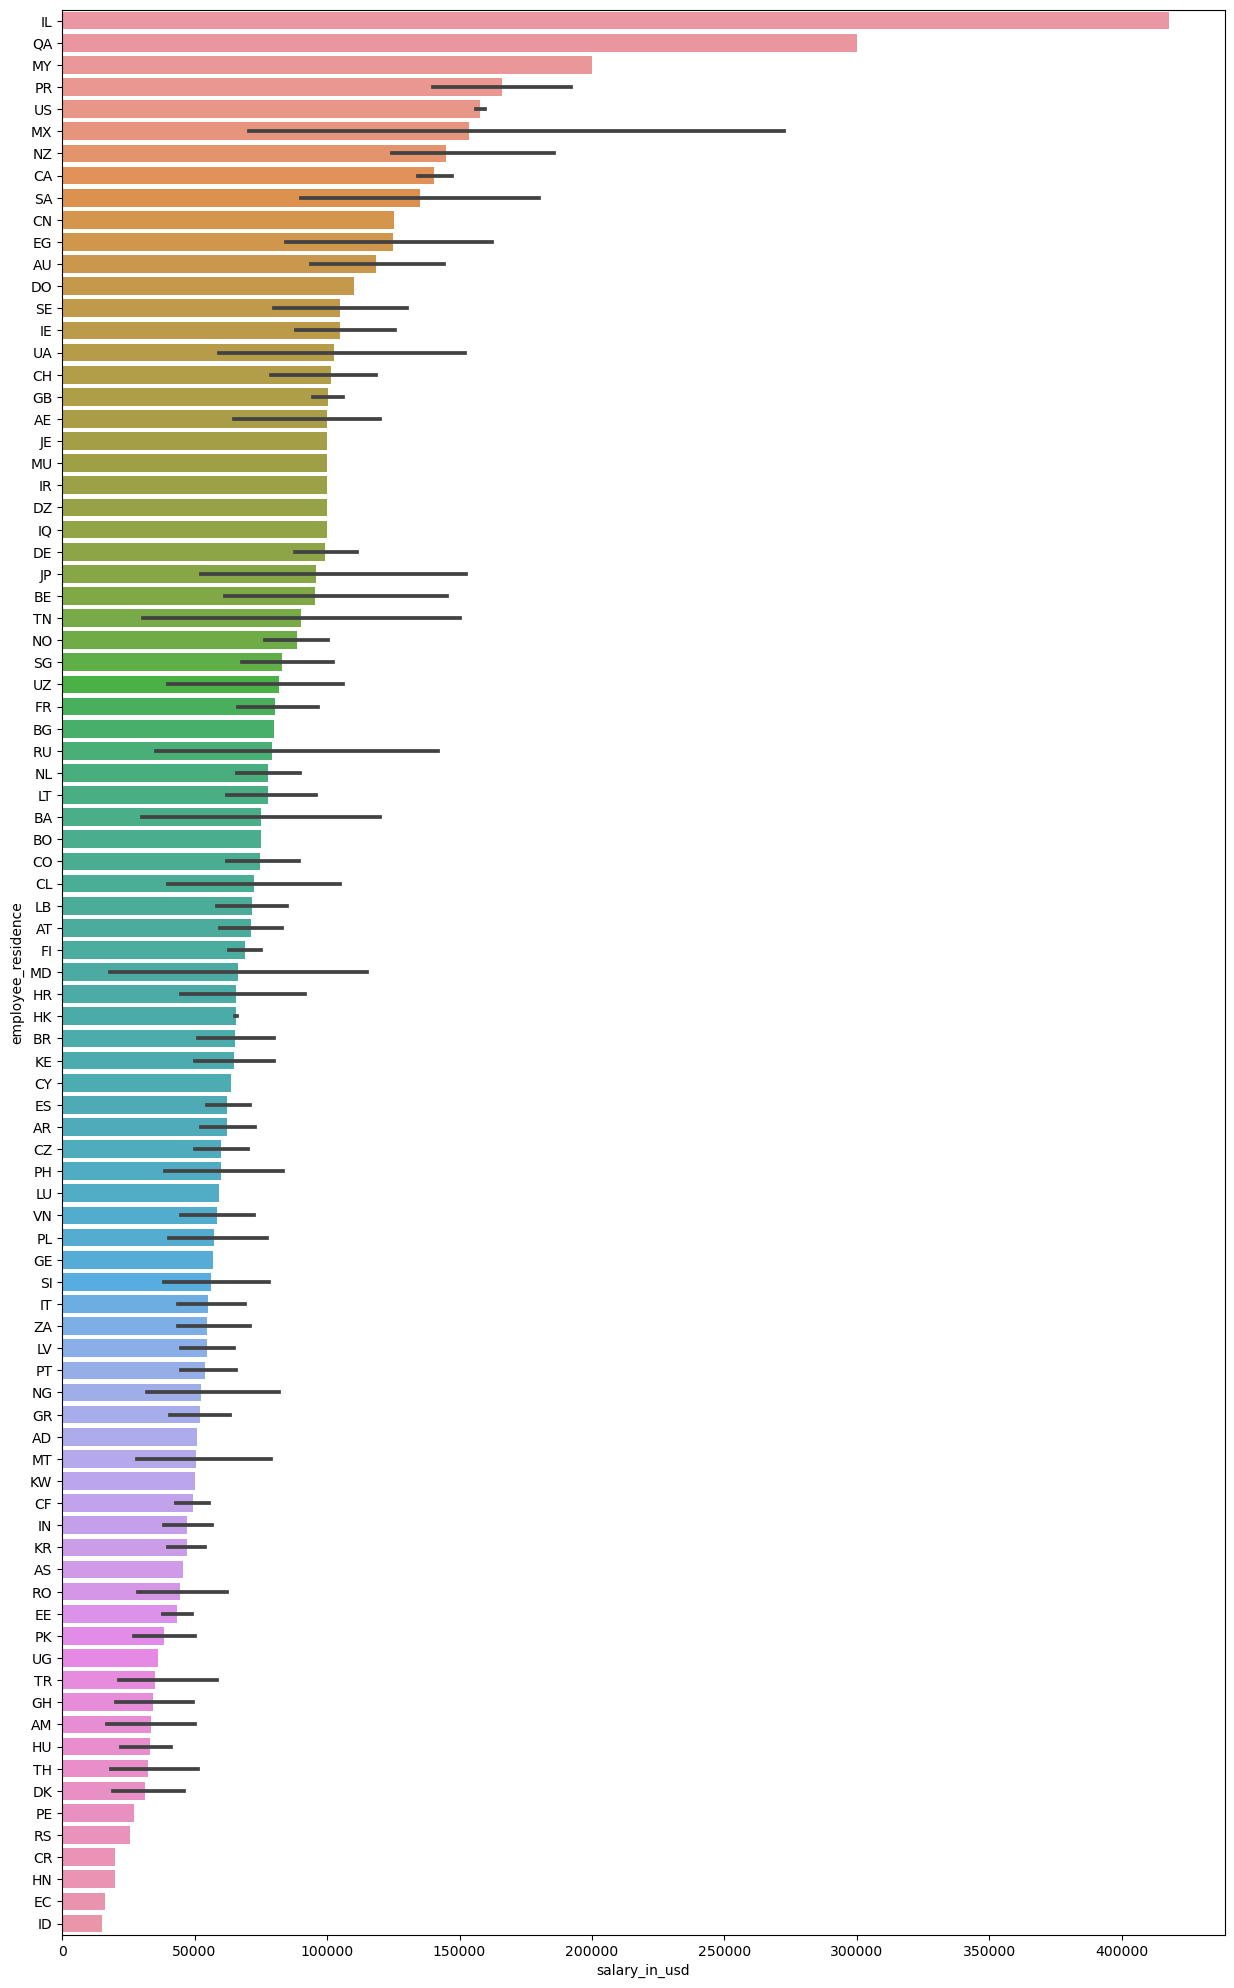

In [26]:
ordering_bar = df[['employee_residence','salary_in_usd']].groupby('employee_residence').mean().reset_index().sort_values('salary_in_usd',ascending=False)

plt.figure(figsize=(15,25))
sns.barplot(data=df,x='salary_in_usd',y='employee_residence',orient='hor',order=ordering_bar['employee_residence'])

There is a large amount of variability in the salary by country so an important feature that needs to be a part of the model.

There are a few possible options here since using the country name as a catergorical column is slightly problematic due to many countries only represented once. 
1. Group less reported countries as other (e.g. countries with less than 10 salaries reported).

I feel like this step gives up lots of information unnecessarily and there are potentially better options. e.g. at the bottom of the list there is Costa Rica, Peru, Ecuador, Honduras which are all very close geographically and are clustered together average salary-wise. 

2. Replace Country with a numeric metric that that would strongly influence the salary in a given country.

This is elaborated on in the next section.

3. Replace the Country with the coordinates to allow the model to account for geographical location.

Locations can be grabbed from here: https://developers.google.com/public-data/docs/canonical/countries_csv or here https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state/data as a directly downloadable csv (but sourced from the first link)

#### Numeric Metric to replace Country
The Purchasig Power Parity (PPP) determines the cost of a basket of goods in a given country. Inherently it should dictate the strength of usd in a given country and is freely available from various sources. I will use the CIA datasource https://www.cia.gov/the-world-factbook/field/real-gdp-per-capita/country-comparison/ as it is the most complete. For example it is the only source which provides a value for Jersey. In this case, I will need to use the GDP per capita adjusted by PPP which represents the adjusted average salary by country considering the strength of the currency.

As the CIA dataset is the only complete dataset corrected by PPP, the data is limited by a single value for each country. So the assumption is that this value is representative of the GDP of each country over the 2020 to 2024 time period. With that said, we do have a column for year which should at least partially account for inflation separately.

I will also merge in coordinates for each country from a custom dataset consisting GDP adjusted by PPP and coordinates, merged from the datasources listed above using the country codes.

In [27]:
country_gdp = pd.read_csv('GDP_and_coordinates.csv',index_col='country_code')
country_gdp[['GDP']]

,GDP
country_code,
LI,139100
MC,115700
LU,115700
SG,106000
IE,102500
...,...
MZ,1200
NE,1200
CD,1100


In [28]:
df = df.merge(country_gdp[['GDP']],left_on='employee_residence',right_index=True,how='left')
df.rename(columns={'GDP':'employee_residence_gdp'}, inplace=True)

df = df.merge(country_gdp[['GDP']],left_on='company_location',right_index=True,how='left')
df.rename(columns={'GDP':'company_location_gdp'}, inplace=True)

df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_clean,outsourced,employee_residence_gdp,company_location_gdp
0,2024,SE,FT,Data Architect,363000,US,0,US,M,Data Architect,False,63700,63700
1,2024,SE,FT,Data Architect,139800,US,0,US,M,Data Architect,False,63700,63700
2,2024,MI,FT,Data Scientist,109000,US,100,US,M,Data Science,False,63700,63700
3,2024,MI,FT,Data Scientist,93000,US,100,US,M,Data Science,False,63700,63700
4,2024,MI,FT,Research Engineer,38888,PT,0,PT,M,Research Engineer,False,33700,33700


Pearson score: 0.10366


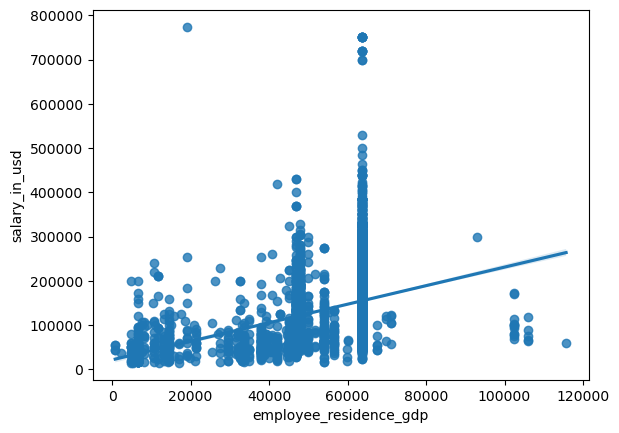

In [29]:
model = LinearRegression()
x = np.array(df['employee_residence_gdp']).reshape(-1, 1)
y = np.array(df['salary_in_usd']).reshape(-1, 1)
model.fit(x,y)
print('Pearson score: {}'.format(round(model.score(x,y),5)))

sns.regplot(data = df, x='employee_residence_gdp',y='salary_in_usd')
plt.show()

The GCP(PPP) per country of the employee residence (or company location) is not an obviously strong indicator for salary. For example with a linear regression model, the gdp only accounts for ~12% of the variation in the salary. Nevertheless deeper relationships could be identified in the model and the feature importance would be a great indicator after model training.

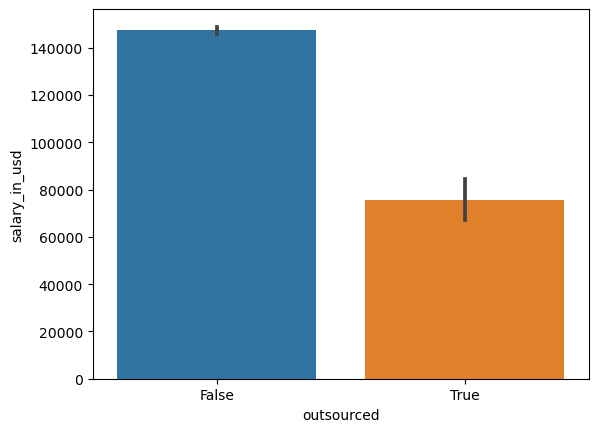

In [30]:
sns.barplot(data=df,x='outsourced',y='salary_in_usd')
plt.show()

Outsourced employees generally just over half the salary of employees co-located with their company.

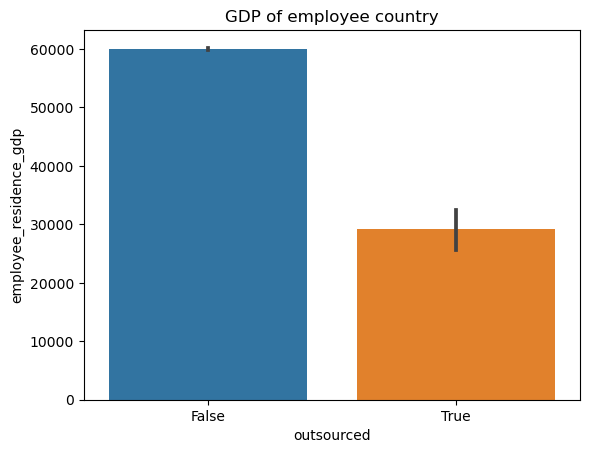

Top 10 most popular countries for outsourced employees:

employee_residence
IN    16
FR     7
IT     7
US     6
ES     6
PK     5
DE     5
AR     4
CA     4
UZ     3
Name: count, dtype: int64

Number of countries represented: 54


In [31]:
sns.barplot(data=df, x='outsourced',y='employee_residence_gdp')
plt.title('GDP of employee country')
plt.show()

print('Top 10 most popular countries for outsourced employees:\n')
print(df[df['outsourced']==True]['employee_residence'].value_counts().head(10))

print('\nNumber of countries represented: {}'.format(len(df[df['outsourced']==True]['employee_residence'].unique())))

The data suggests that outsourced employees generally are live in countries with a lower GDP e.g. The highest number of outsourced employees live in India. Although there are many countries such as France, Italy etc. with high GDP

### Company Size

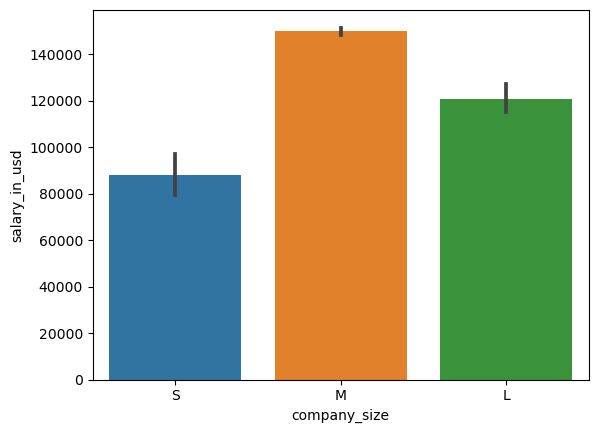

In [32]:
sns.barplot(data=df[['salary_in_usd','company_size']],x='company_size',y='salary_in_usd',order=['S','M','L'])
plt.show()

The company size column appears to be a good indicator of employee salary. Salary is highest for Medium sized companies, followed by Large companies with Small companies paying the lowest average salary

In [33]:
df['company_size'].value_counts()

company_size
M    7180
L     595
S     175
Name: count, dtype: int64

In [34]:
df[df['outsourced']==False]['employee_residence'].value_counts().head(10)

employee_residence
US    6460
GB     458
CA     289
DE      79
ES      67
IN      57
FR      48
AU      30
PT      27
NL      21
Name: count, dtype: int64

In [35]:
df = df.merge(country_gdp[['latitude','longitude']],left_on='employee_residence',right_index=True,how='left')
df.rename(columns={'latitude':'employee_latitude','longitude':'employee_longitude'}, inplace=True)

In [36]:
df = df.merge(country_gdp[['latitude','longitude']],left_on='company_location',right_index=True,how='left')
df.rename(columns={'latitude':'company_latitude','longitude':'company_longitude'}, inplace=True)

In [37]:
df.to_csv('data_science_salaries_clean.csv')

PermissionError: [Errno 13] Permission denied: 'data_science_salaries_clean.csv'

## Data Cleaning Summary

The dataset had no missing data and required very little cleaning. The cleaned and augmented dataset is saved as `data_science_salaries_clean.csv`

### Existing columns

1. `experience_level`, `employment_type`, `work_models`, `work_year`, `employee_residence`,`salary_in_usd`, `company_location`, `company size`,`job_title` columns were unmodified.

2. The `salary` and the `salary_currency` columns were dropped.


### New columns
1. `co_located` column was created by checking whether the `company_location` and `employee_residence` columns are the same. The data in the column is boolean where True indicates that the employee and company reside in the same locationa and False indicates that the employee lives in a different country from the company.

2. `employee_residence_gdp` and `company_location_gdp` were joined in from a new datasource which contained the per capita GDP adjusted by PPP for each country

3. `company_latitude`, `company_longitude`, `employee_latitude`, `employee_longitude` were joined from a new datasource. They simply contain the coordinates for the data in the `company_location` and the `employee_residence` columns.

4. `job_title_clean` was created from the `job_title` column to consolidate job titles, e.g. adding missing acronyms, regional spellings, 
### Notes for later

The full vocabulary of possible single words in the `job_title` column is stored as a separate text file called `vobaulary.json`

Code to read in the json file later:

`with open("file.json", 'r') as f:`

   `>>>>list = json.load(f)`
   
## Data Visualization Summary

Preliminary visualization was performed but a dashboard will be prepared with Tableau.

The cleaned dataset will be used for the Tableau visualisation

`experience_level` Salary increases linearly with experience level, ranging from \\$80,000 for entry level to \\$200,000 for executive level

`employment_type` Full time and contract have much higher salary, around 100% more than part time and freelance

`work_models` Hybrid employment pays significantly less, 60% of on-site and remote employment

`work_year` Salary has been steadily increasing over the the 5 year time period

`employee_residence` and `company location` impact the salary but the relationship between gdp(ppp) is hard to determine without a model

`company size` Medium companies pay the most, followed by large and then small companies which pay about 60% of the salary of medium companies

`outsourced` Outsourced employees are paid about 50% of their non outsourced counterparts